In [1]:
%config Completer.use_jedi = False

From HyunWoo Kim

In [2]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [39]:
pd.options.display.max_columns = 30

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print('train shape: ', df_train.shape)
print('test shape: ', df_test.shape)

train shape:  (15035, 21)
test shape:  (6468, 20)


In [5]:
df_train.price.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

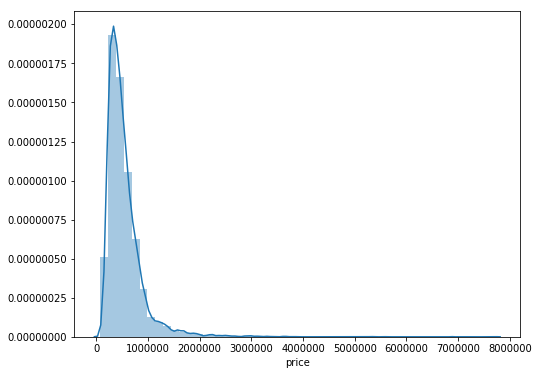

In [6]:
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(df_train['price'])

In [8]:
print('Skewness: {}'.format(df_train["price"].skew()))
print('Kurtosis: {}'.format(df_train['price'].kurt()))

Skewness: 4.290252396939529
Kurtosis: 40.15491919350329


### Normalize 필요

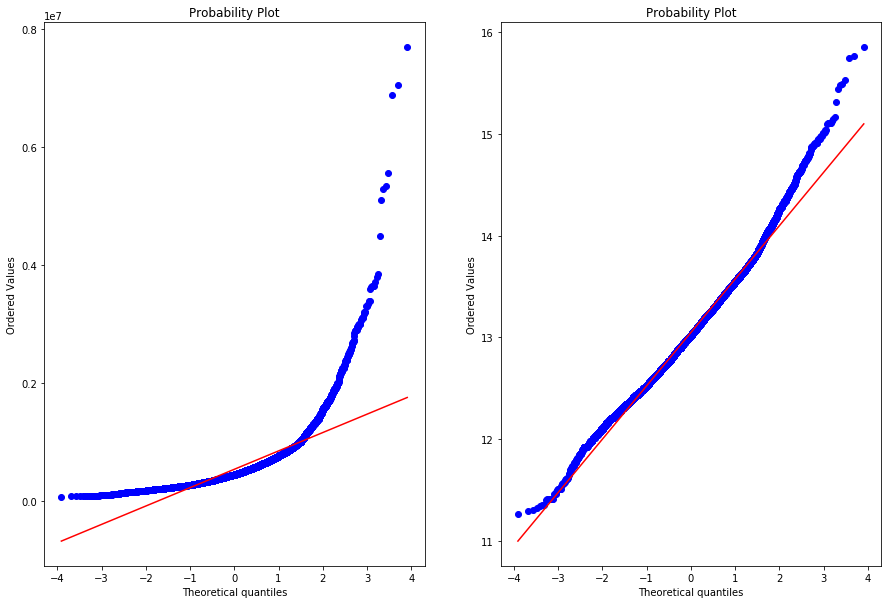

In [10]:
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)
#log1p, 로그 취했을 때 세부값까지 가져옴

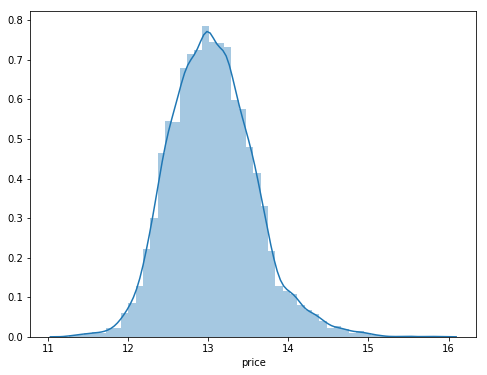

In [11]:
df_train['price'] = np.log1p(df_train['price'])
f, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_train['price']) #모양이 예뻐졌다.

## 변수시각화 ( 반응변수 )
* 피어슨 상관관계 : 연속형 변수에 사용
* 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

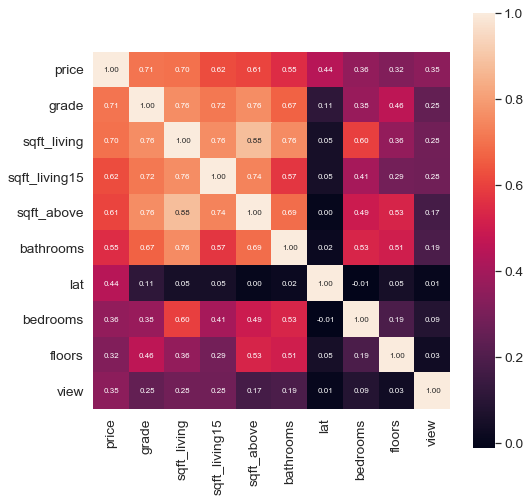

In [12]:
#스피어만을 살펴보자
k = 10 #num of vars
corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(k, 'price').index
cm = np.corrcoef(df_train[cols].values.T)

sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize = (8,8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size':8}, 
                 yticklabels = cols.values, xticklabels = cols.values)

plt.show()
                     

목적변수와 관련 높은 변수 price - grade, sqft_living, sqft_living15

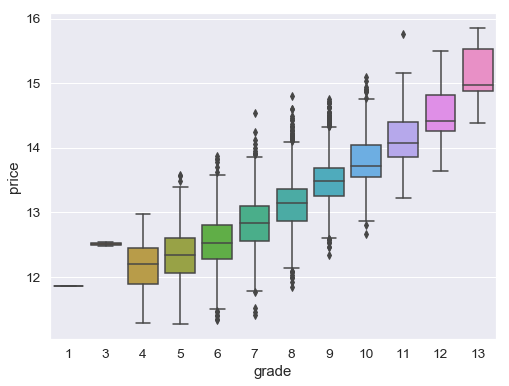

In [17]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='grade',y='price', data=data)

집의 등급이 높으면 가격도 올라간다, 6,7,8,9에서 보이는 많은 이상치  
8, 11 에서 보이는 차이가 큰 이상치

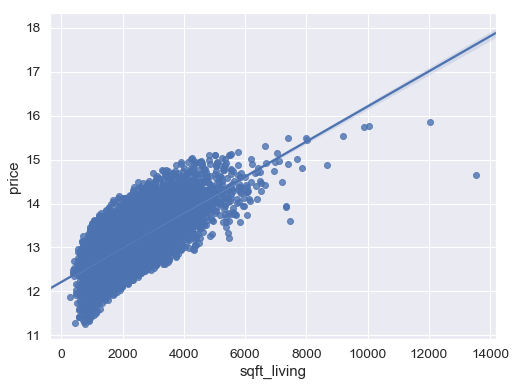

In [18]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x = 'sqft_living', y = 'price', data=data)

price 14 15 구간에서 이상치로 보이는 데이터가 발견된다. 확인해야 할 부분

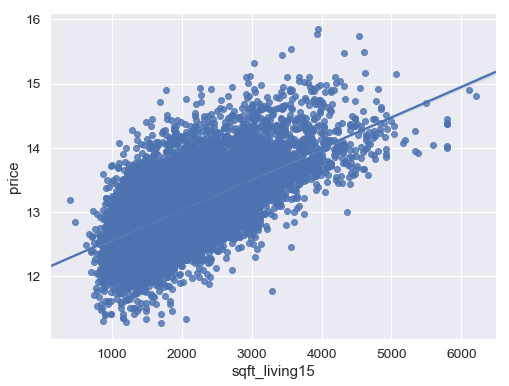

In [20]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize= (8,6))
fig = sns.regplot(x = 'sqft_living15', y = 'price', data=data)

15년도를 기준, 분산이 굉장히 크다는 것을 알 수 있음, 재겆축의 영향??  
분산을 줄이기 위해 적절한 feature engineering이 필요

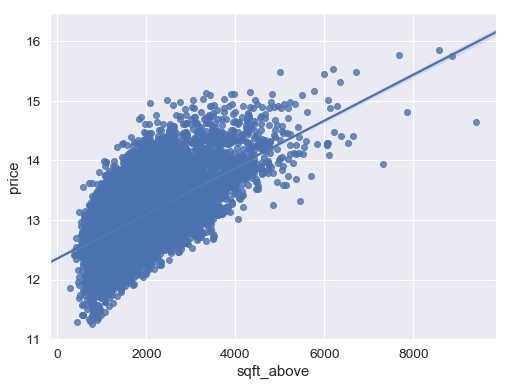

In [21]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x = 'sqft_above', y = 'price', data=data)

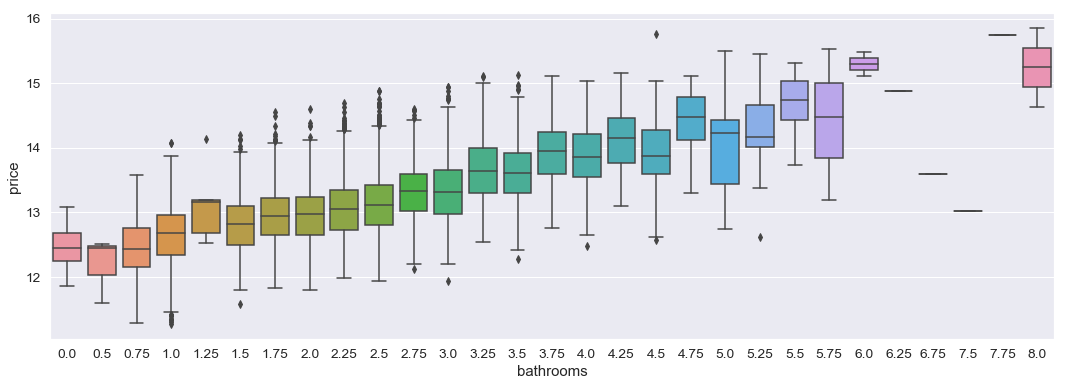

In [22]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

* 0.5 : 세면대, 화장실
* 0.75 : 세면대, 화장실, 샤워실
* 1 : 세면대, 화장실, 샤워실, 욕조

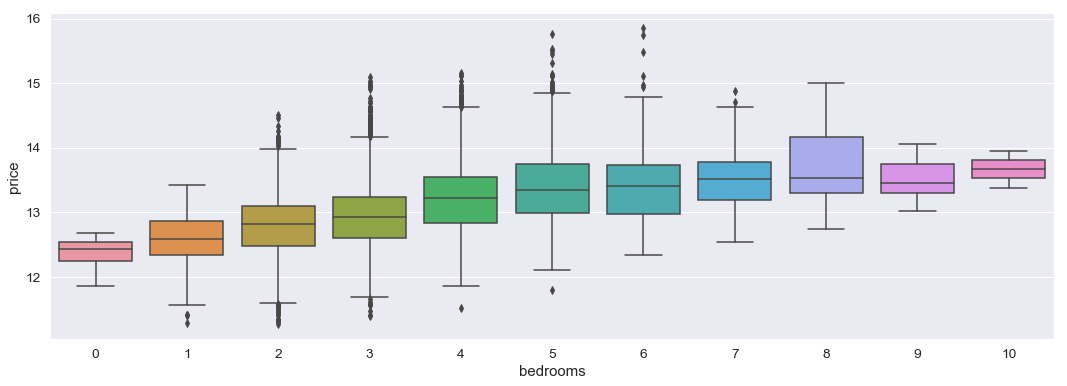

In [23]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [27]:
max(df_test['bedrooms'])

33

test 데이터에는 방이 30개가 넘는 게 발견됨.

lat(위도)에 대하여, Seatle쪽은 위쪽으로 갈 수록 집값이 비싸다고 함.

### Uniqueness

In [28]:
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont = dict(size=20),
        marker=dict(
        line=dict(
        color= generate_color(),
        ), opacity=0.45)),]
    
    

layout  = go.Layout(
    title = 'Unique Value By Column',
    xaxis = dict(title = 'Columns', ticklen=5, zeroline=False, gridwidth=2),
    yaxis = dict(title = 'Value Count', ticklen=5, gridwidth=2),
    showlegend = True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')




NameError: name 'go' is not defined

In [30]:
import plotly

In [ ]:
plotly.graph_objs

In [31]:
### 유니크 갯수 계산
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    plotly.graph_objs.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
layout= plotly.graph_objs.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')


NameError: name 'generate_color' is not defined

In [36]:
### 유니크 갯수 계산
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    plotly.graph_objs.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            #width= 2,
        )
    )
    ),
    ]
layout= plotly.graph_objs.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = plotly.graph_objs.Figure(data=data, layout=layout)
plotly.plotly.iplot(fig, filename='skin')

view의 유니크갯수가 5인걸로 보니 grade같이 순위형변수로 생각되어지고 waterfront의 경우는 2개로 있다/없다는 상징하는 것 같습니다.

## Preprocessing

* 이상치 확인해야 될 columns
     - sqft_living, grade, bedrooms

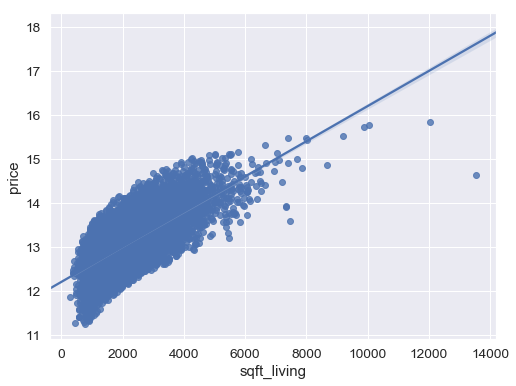

In [37]:
# sqft_living visualize
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [40]:
# 13000보다 큰 데이터를 확인
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [41]:
df_train = df_train.loc[df_train['id']!=8990]

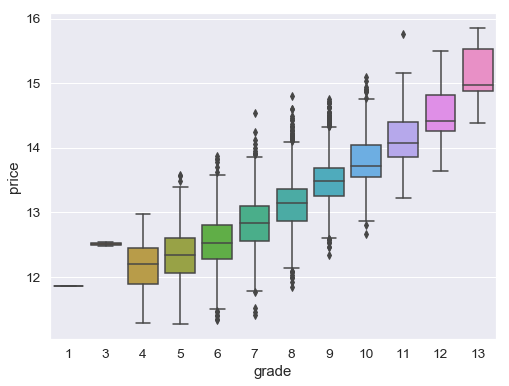

In [42]:
# grade
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [43]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] ==8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [44]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


왜 가격이 높은 걸까 생각

In [45]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

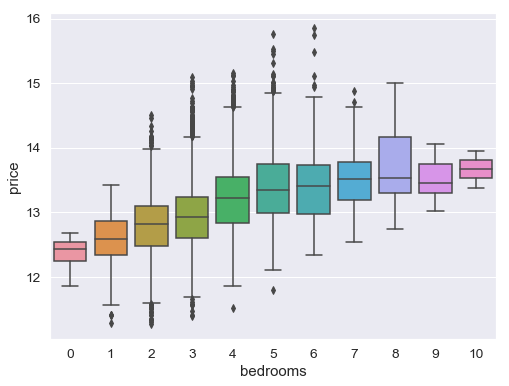

In [46]:
# bedrooms
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

10이상 부터는 증가하지 않는다?

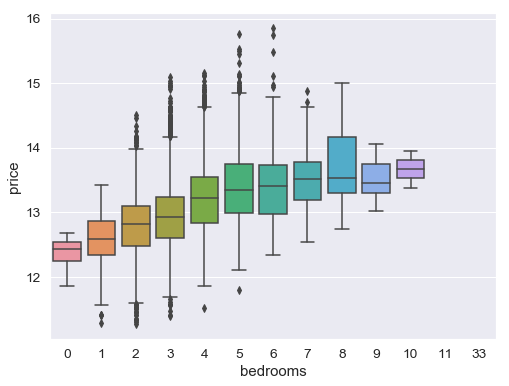

In [50]:
data = pd.concat([for_bed['price'], for_bed['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [51]:
df_train.loc[df_train['bedrooms']>=10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9280,9280,20140814T000000,13.953533,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
10575,10575,20141029T000000,13.384729,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914


In [52]:
df_test.loc[df_test['bedrooms']>=10]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2584,17619,20140821T000000,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
4710,19745,20140625T000000,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
5775,20810,20141229T000000,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


### Normalize

In [53]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [54]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [55]:
for df in [df_train,df_test]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['grade_condition'] = df['grade'] * df['condition']
    df['sqft_total'] = df['sqft_living'] + df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')